# Demo

The `route_calc` package is a minimal object-oriented approach to weighted graph construction and route-finding. It leverages common data structures and algorithms such as adjacency lists, depth-first search, and Dijkstra's algorithm to frame the central problem of finding the shortest path from one point in a city to another.

In the process of implementing this tool, we have made a few assumptions:

- All locations have an edge (i.e. route) that connects to all other locations in the adjacency list.
- All routes between two locations have the same weight (i.e. duration) regardless of the direction traversed. By this logic, any delay or blockage that occurs on these routes should also be the same in both directions.
- A route blockage is defined to be a route with infinite duration.

Let's begin by taking a look at some of the data structures.

## Location

In [1]:
from route_calc import Location

The `Location` class houses information pertaining to each node of a weighted graph. In these objects, we store the name of the location (string), and optionally the latitude (float) and longitude (float), both in degrees.

In [2]:
example_location_1 = Location(
    name="Example Location",
    latitude=10,
    longitude=20,
)
example_location_2 = Location(
    name="Another Example Location",
    latitude=30,
    longitude=40,
)

## Map
To store these vertices, we use the `Map` class. This structure utilizes an adjacency list to store each location node as a dictionary key. The values are weight mappings for each ending node of a route.

```python
adjacency_list = {
    starting_location_node: {
        ending_location_node_1: 5,
        ending_location_node_2: 10,
        ending_location_node_3: 15,
    }
}
```

In [3]:
from route_calc import Map

### Add Routes

To use `Map`, we start by initializing an empty map, and then calling the `add_route` method. In the context of our problem, the `duration` parameter of the `add_route` method is equivalent to the weight of an edge between two vertices. Additionally, `Map` takes two optional parameters:

- `time_units` (string): The unit of measure used for duration. Defaults to "minutes"
- `verbose` (boolean): Toggles the verbosity of print statements. Defaults to False

In [4]:
example_map = Map()
example_map.add_route(start=example_location_1, end=example_location_2, duration=10)
example_map

Map of 2 locations and 2 possible routes

We can see here that `example_map` now has 2 locations with two possible routes between these locations (i.e. to and from the starting node).

### Calculate Duration
We may also want to calculate the shortest path between two locations in the map. To do so, use the `calculate_duration` class method. While our example only has two nodes, this method works well with several nodes as well by utilizing Dijkstra's algorithm in the backend.

In [5]:
duration = example_map.calculate_duration(
    start=example_location_1,
    end=example_location_2,
)
print(f"{duration} {example_map.time_units}")

10 minutes


## Construct Path
We can visualize the locations traversed using the `construct_path` method:

In [6]:
example_map.construct_path(
    start=example_location_1,
    end=example_location_2,
)

[Example Location, Another Example Location]

## Readers

Now that we have a general idea of how `Location` and `Map` works, we can apply these to a larger data set. For the purposes of our project, we selected 10 locations in Boston, Massachusetts. To ease the user interaction with larger data sets, we have implemented two reader functions: `read_locations` and `read_routes`. The former takes in a path to a CSV file which reads in a list of `Location` objects. This can (optionally) be passed to `read_routes` along with a path to another CSV file which reads in the starting location, ending location, and duration of each route. If the list of `Location` objects is indeed passed to the function, it will automatically match a `Location` object with the corresponding name from the CSV file. The `read_routes` function then takes these routes and constructs a `Map` object from them.

In [7]:
from route_calc import read_locations, read_routes

In [8]:
locations = read_locations("../data/locations.csv")
city_map = read_routes("../data/routes.csv", locations=locations)

Now we can see how our class methods perform in a more realistic setting:

In [9]:
duration = city_map.calculate_duration(
    "Museum of Fine Arts Boston", "Bunker Hill Monument"
)
print(f"{duration} {city_map.time_units}")

12.0 minutes


In [10]:
city_map.construct_path(
    start="Museum of Fine Arts Boston",
    end="Bunker Hill Monument",
)

[Museum of Fine Arts Boston, Bunker Hill Monument]

## Visualizer
The `route_calc` package also comes with a few useful visualizer tools which leverage networkx, matplotlib, and Plotly.

In [11]:
from route_calc import plot_nodes, plot_map, plot_route

### Plot a Network of Location Nodes

We can visualize how each location relates to one another using the `plot_nodes` function.

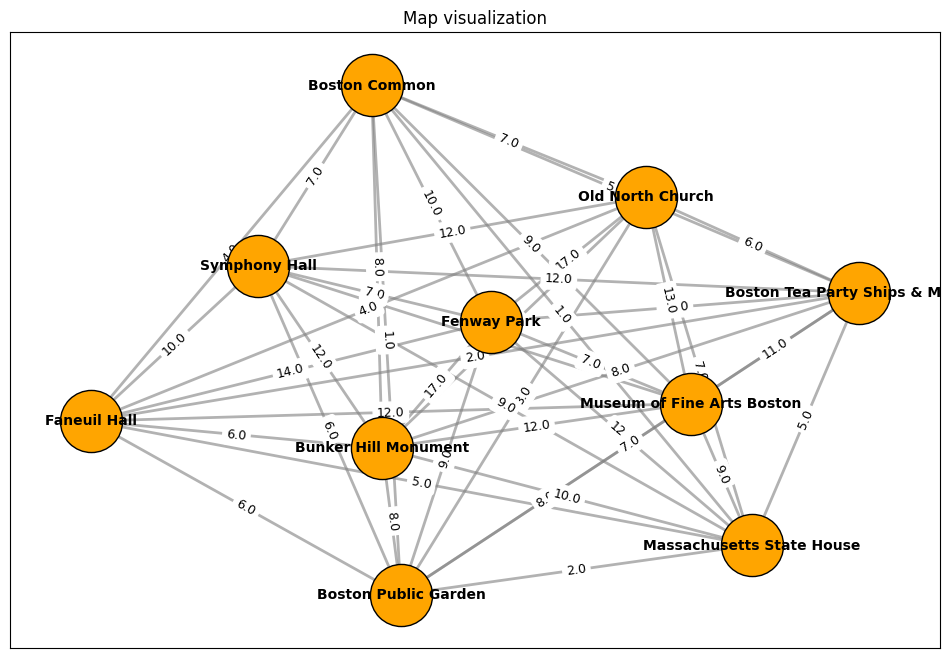

In [12]:
network_fig = plot_nodes(city_map)
network_fig.savefig("network.png")

### Plot a Route on Multiple Maps

The `plot_route` function takes in a list of maps, their titles, and a starting and ending location of a route.

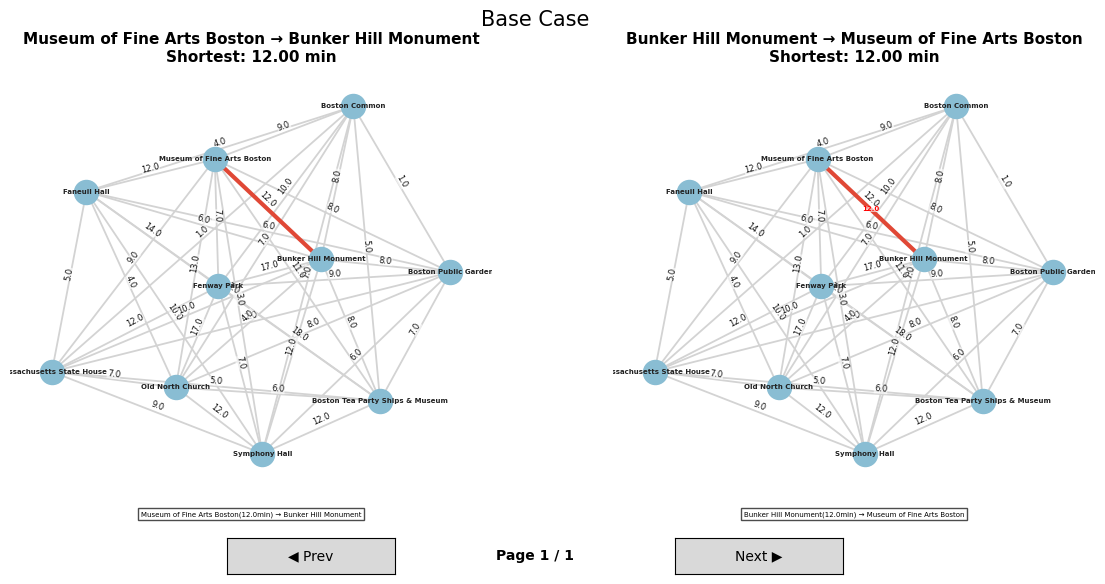

In [13]:
route_fig = plot_route(
    maps=[city_map],
    titles=["Base Case"],
    start="Museum of Fine Arts Boston",
    end="Bunker Hill Monument",
)

### Plot on a Map
Using the `plot_map` function, our tool creates an interactive Plotly Scattermap which displays each location node connected with edges, and labeled with durations. Since the output is a Plotly `Figure` object, we may take advantage of all the built-in Plotly functionality, such as saving it as an HTML file.

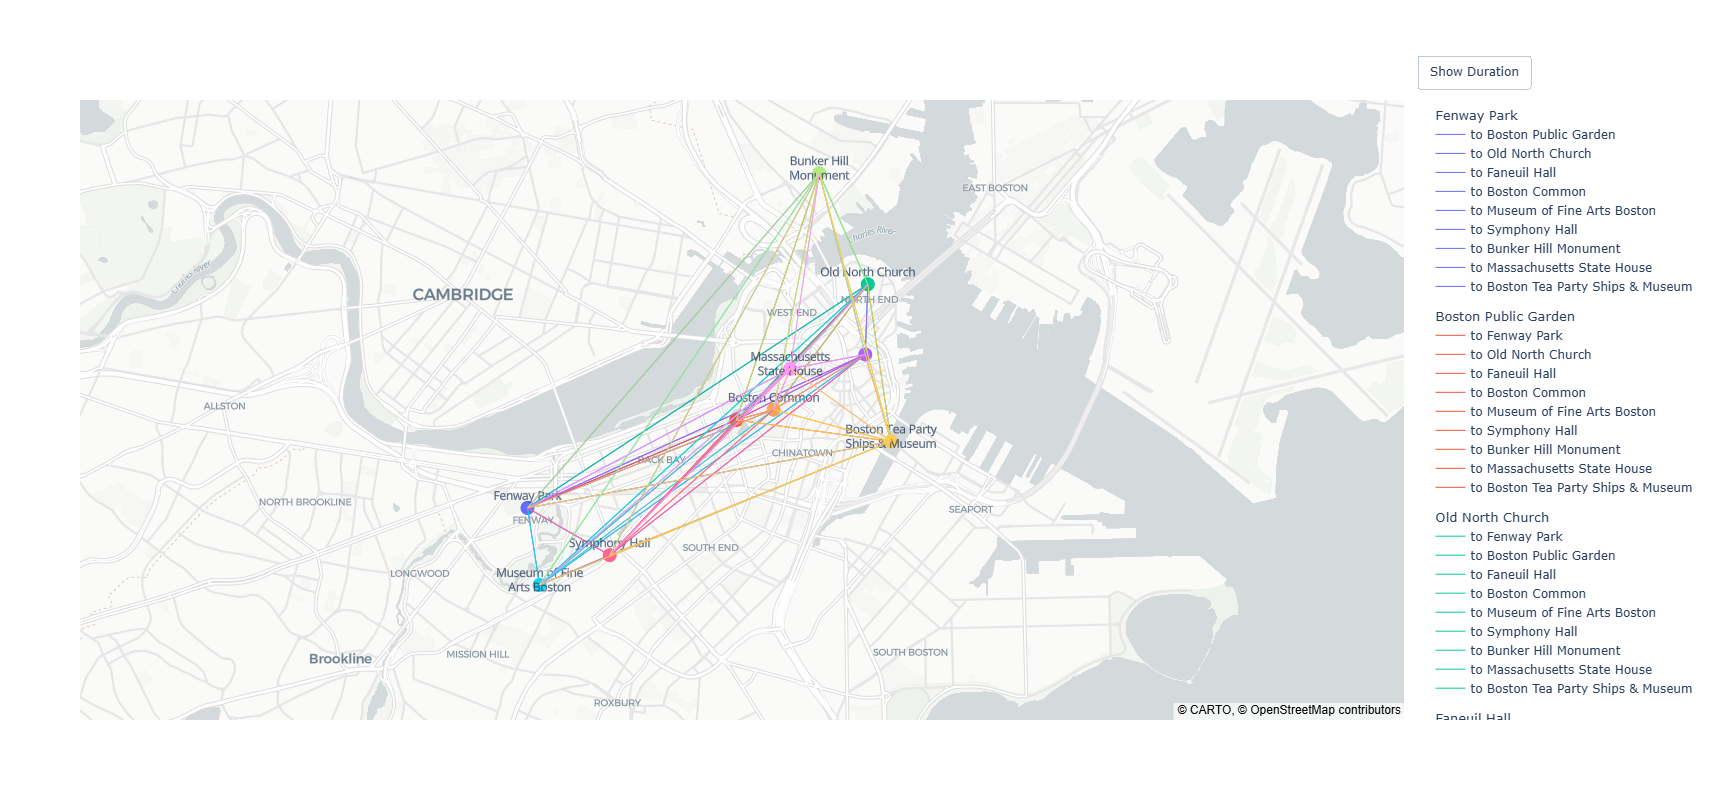

In [14]:
map_fig = plot_map(city_map)
map_fig.write_html("map.html")
map_fig.update_layout(height=800)
map_fig.show()

## Traffic Simulator

Sometimes, we may want to simulate how routes may behave when there's traffic or extreme events such as a route blockage. To do so, we can use the `simulate_traffic` function. This method essentially applies a randomly generated multiplier to each route within a map to simulate varying traffic conditions. A risk factor may also be attributed to a specified number of routes which determines the likelihood of an extreme event taking place.

To give the user options to customize their simulation, we have a number of parameters that can be tuned:

- `map` (Map): The `Map` object that houses all of the routes
- `min_delay` (float): The minimum multiplier that may be applied to a route's duration
- `max_delay` (float): The maximum multiplier that may be applied to a route's duration
- `risk` (float): The chance that a route will experience an extreme event such as a severe delay (10+ times the duration) or road blockage. We have hard-coded to to be a 20% chance that an extreme event will be a blockage. A domain from 0 to 1 (inclusive) is enforced.
- `risk_count` (integer): The number of events to which we may apply this risk factor

In [15]:
from route_calc import simulate_traffic

In [16]:
rush_hour_map = simulate_traffic(
    map=city_map,
    min_delay=1,
    max_delay=3,
    risk=0.2,
    risk_count=3,
)

We can now see the power of Dijkstra's algorithm as the shortest path between two locations may not necessarily be the route directly connecting them!

In [17]:
duration = rush_hour_map.calculate_duration(
    "Museum of Fine Arts Boston", "Bunker Hill Monument"
)
print(f"{duration:.1f} {rush_hour_map.time_units}")

26.0 minutes


In [18]:
rush_hour_map.construct_path(
    start="Museum of Fine Arts Boston",
    end="Bunker Hill Monument",
)

[Museum of Fine Arts Boston,
 Boston Public Garden,
 Boston Common,
 Bunker Hill Monument]

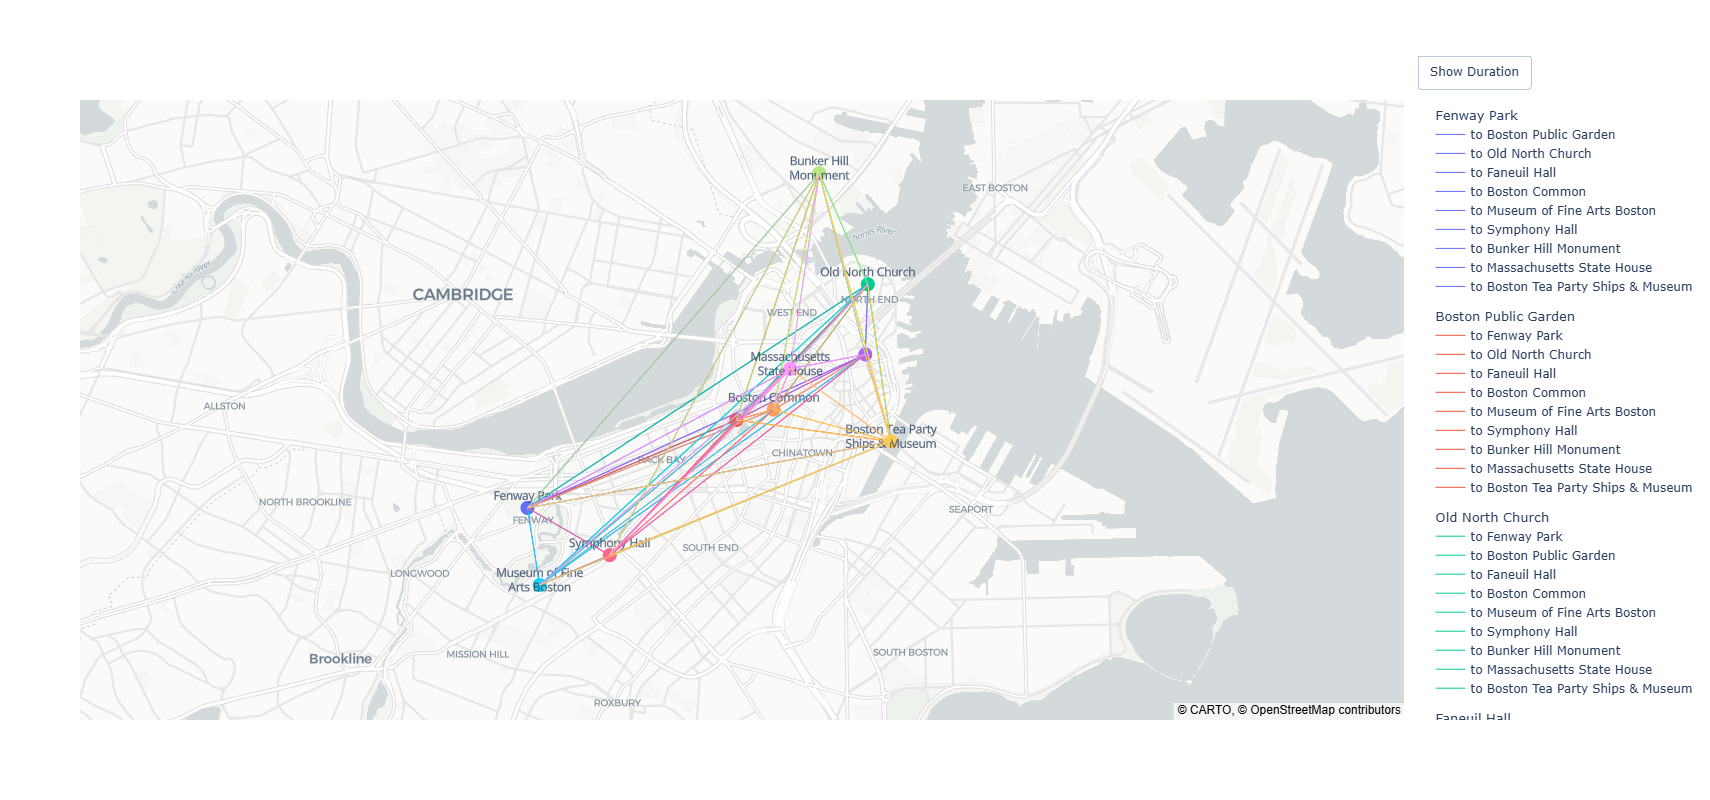

In [20]:
map_fig = plot_map(rush_hour_map)
map_fig.write_html("rush_hour.html")
map_fig.update_layout(height=800)
map_fig.show()